In [1]:
from dpt_run import *
from utils import *

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# problem = problems.SimpleQuadratic(d=1, n=1024, seed=np.random.randint(1024))
# show_problem(problem)

In [4]:
from torch.nn import functional as F

def run(model, sample):
    if "x" in sample and "y" in sample:
        logits = model.model(
            x=sample["x"].unsqueeze(0).to(device),
            y=sample["y"].unsqueeze(0).to(device),
        ).squeeze(0).detach().cpu()
        x = sample["x"].cpu()
        y = sample["y"].cpu()
    else:
        results = model.run(
            problem=sample["problem"],
            n_steps=model.config["model_params"]["seq_len"]+1
        )
        logits = results['logits'].detach().cpu()
        x = results["x"].cpu()
        y = results["y"].cpu()
    probs = F.softmax(logits, -1)
    return {"logits": logits, "probs": probs, "x": x, "y": y, "target": sample["x_min"], "problem": sample["problem"]}

def show(results, title=""):
    probs = results["probs"]

    cmap = cm.get_cmap('jet')
    fig, axes = plt.subplots(1, 2, figsize=(16, 4), gridspec_kw=dict(wspace=0.125))
    plt.suptitle(title)
    axes[1].set_title("Predicted Distribution")
    show_problem(results["problem"], ax=axes[0], color="grey", linestyle='--')

    if probs.ndim == 2:
        colors = [cmap(c) for c in np.linspace(0, 1, len(probs))]
        for i in np.linspace(0, len(probs)-1, 10+1, dtype=np.int32):
            axes[0].scatter(results["x"][:i], results["y"][:i], c=colors[:i], zorder=2)
            axes[1].plot(results["probs"][i], c=colors[i], label=i)
    else:
        color = cmap(1.0)
        axes[0].scatter(results["x"], results["y"], color=color, zorder=2)
        axes[1].plot(results["probs"], c=color, label=len(results["x"]))

    ymin, ymax = axes[1].get_ylim()
    axes[1].vlines(x=results["target"], ymin=0, ymax=ymax, colors='white', label='target')

    plt.legend(loc=4)
    plt.show()

def runnshow(model, idx=0):
    model.train()
    with torch.no_grad():
        train_batch_train_mode = run(model, train_offline_dataset[idx])
        valof_batch_train_mode = run(model, val_offline_dataset[idx])
        show(train_batch_train_mode, title="Train problem: Offlain Training")
        show(valof_batch_train_mode, title="Validation problem: Offlain Training")

    model.eval()
    # train_batch_eval_mode = run(model, train_offline_dataset[idx])
    # valof_batch_eval_mode = run(model, val_offline_dataset[idx])
    valon_batch_eval_mode = run(model, val_online_dataset[idx])
    # show(train_batch_eval_mode, title="Train problem: Offlain Inference")
    # show(valof_batch_eval_mode, title="Validation problem: Offlain Inference")
    show(valon_batch_eval_mode, title="Validation problem: Onlain Inference")

In [5]:
config = load_config("dpt_run_config.yaml")
dl = get_dataloaders(config)

train_offline_dataloader = dl["train_dataloaders"]
val_offline_dataloader = dl["val_dataloaders"][0]
val_online_dataloader = dl["val_dataloaders"][1]

train_offline_dataset = train_offline_dataloader.dataset
val_offline_dataset = val_offline_dataloader.dataset
val_online_dataset = val_online_dataloader.dataset

train_offline_batch = next(iter(train_offline_dataloader))
val_offline_batch = next(iter(val_offline_dataloader))
val_online_batch = next(iter(val_online_dataloader))

train_offline_dataset: 900
val_offline_dataset: 100
val_online_dataset: 100


In [6]:
# multi loss
checkpoint_file = '../GreyBoxDPTOptimizerData/GreyBoxDPTOptimizer_2/dynamic_loss/checkpoints/epoch=499-step=1000.ckpt'
model = DPTSolver.load_from_checkpoint(checkpoint_file).to(device)

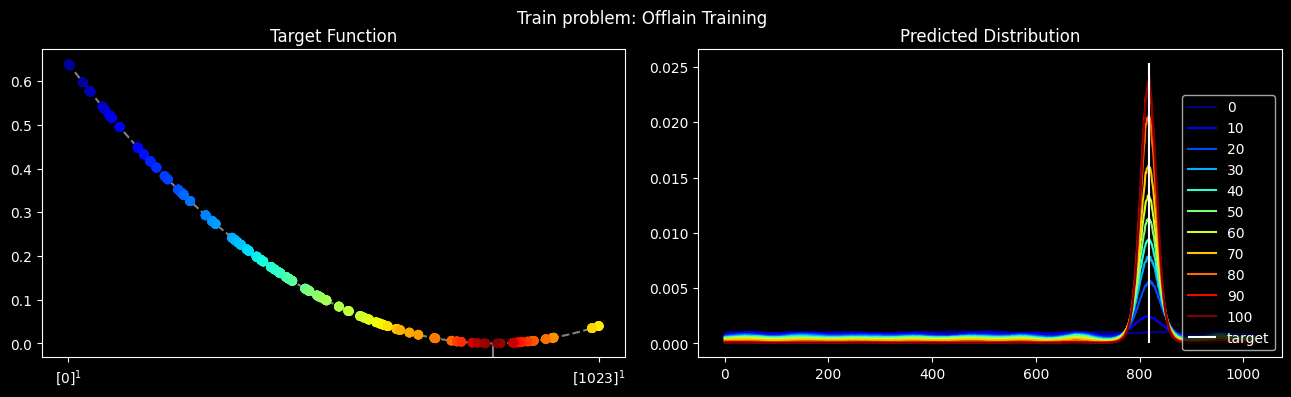

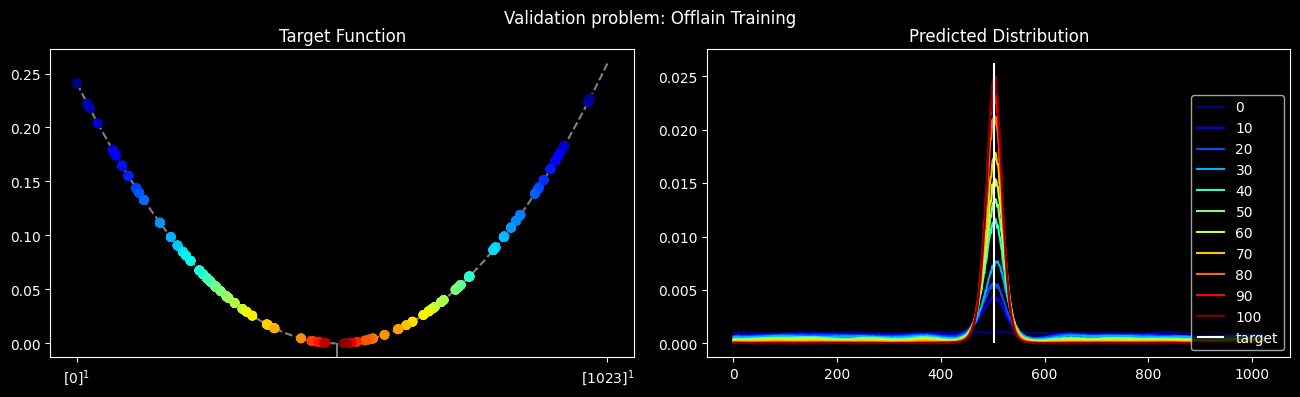

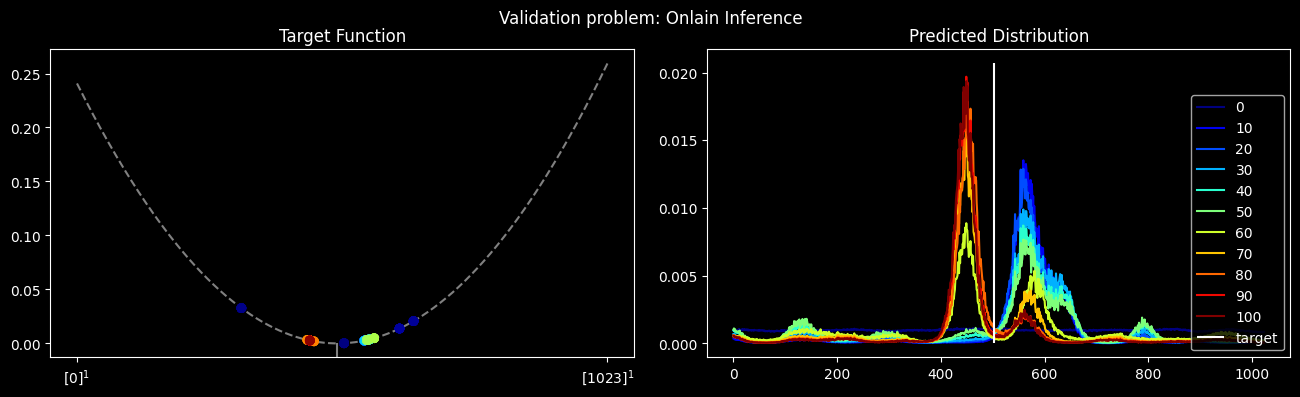

In [8]:
runnshow(model, idx=1)

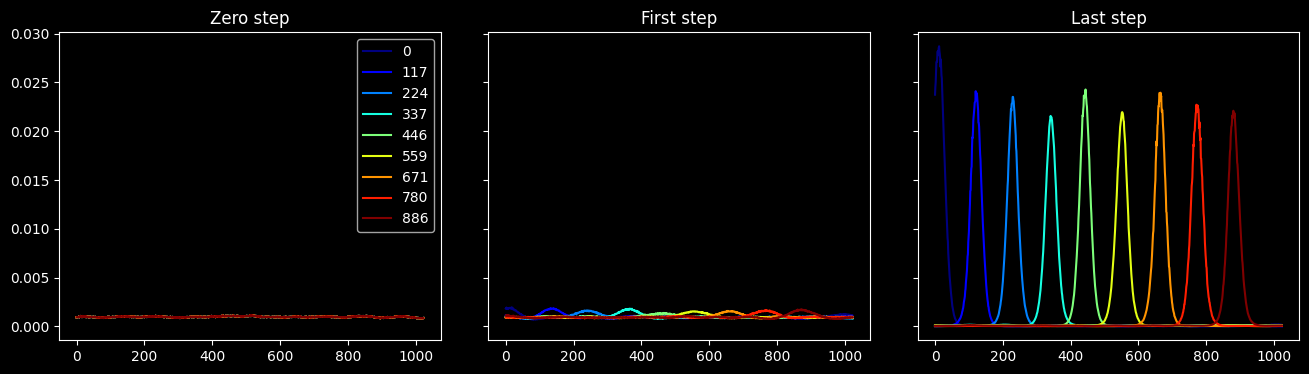

In [9]:
dataset = train_offline_dataset
# dataset = val_offline_dataset
model.train()

# dataset = val_online_dataset
# model.eval()

targets = torch.tensor([dataset[i]["x_min"] for i in range(len(dataset))])
sort_indexes = torch.argsort(targets)[::100]

fig, axes = plt.subplots(1, 3, figsize=(16, 4), gridspec_kw=dict(wspace=0.125), sharey=True)
axes[0].set_title('Zero step')
axes[1].set_title('First step')
axes[2].set_title('Last step')

cmap = cm.get_cmap('jet')
colors = [cmap(c) for c in np.linspace(0, 1, len(sort_indexes))]
for i, c in zip(sort_indexes, colors):
    results = run(model, dataset[i])
    target = results['target'].item()
    axes[0].plot(results['probs'][0], c=c, label=target)
    axes[1].plot(results['probs'][1], c=c, label=target)
    axes[2].plot(results['probs'][-1], c=c, label=target)
axes[0].legend()
plt.show()

### loss

In [10]:
from solvers.dpt.train import Loss

loss = Loss(
    num_classes=config["model_params"]["num_actions"], 
    eps=config["label_smoothing"],
    mode=config["loss"]
)

In [11]:
def runnshow2(results, loss, u):
    # show loss
    plt.figure(figsize=(16, 3))
    plt.title('Loss')
    plt.plot(loss)
    plt.show()

    # compare distributions 1
    fig, axes = plt.subplots(1, 3, figsize=(16, 3), gridspec_kw=dict(wspace=0.05), sharey=True)

    axes[0].set_title('Zero Step')
    axes[1].set_title('Middle Step')
    axes[2].set_title('Last Step')

    axes[0].plot(results["probs"][0], c='red', label='predicted')
    axes[1].plot(results["probs"][len(results["probs"])//2], c='red')
    axes[2].plot(results["probs"][-1], c='red')

    axes[0].plot(u[0], c='blue', label='ground truth')
    axes[1].plot(u[len(u)//2], c='blue')
    axes[2].plot(u[-1], c='blue')

    axes[0].legend()
    plt.show()

    # # compare distributions 2
    # cmap = cm.get_cmap('jet')
    # colors = [cmap(c) for c in np.linspace(0, 1, len(u))]
    # _, axes = plt.subplots(2, 1, figsize=(8, 6))
    # step = 10
    # for i in np.linspace(0, len(u)-1, step+1, dtype=np.int32):
    #     axes[0].plot(results["probs"][i], c=colors[i])
    #     axes[1].plot(u[i], c=colors[i], label=i)
    # axes[1].legend(prop={'size': 8})
    # plt.show()

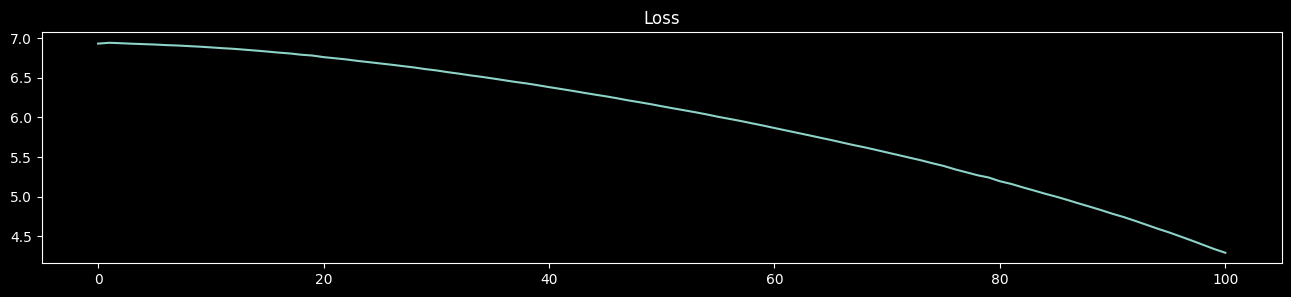

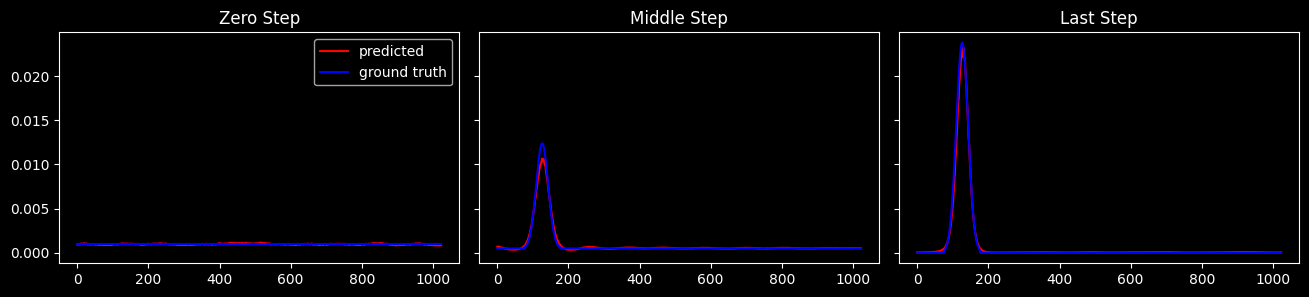

In [14]:
model.train()
results = run(model, train_offline_dataset[0])
# results = run(model, val_offline_dataset[1])

predictions = results["logits"].unsqueeze(0).to(device)
targets = results["target"].unsqueeze(0).repeat(1, config["model_params"]["seq_len"]+1).to(device)
l = loss(predictions, targets, reduction='none').squeeze(0).cpu()
u = loss.u.squeeze(0).cpu().T

runnshow2(results, l, u)

### gif

In [20]:
from matplotlib.animation import FuncAnimation, PillowWriter

def gif(results, title='result'):
    probs = results["probs"]

    cmap = cm.get_cmap('jet')
    colors = [cmap(c) for c in np.linspace(0, 1, len(probs))]
    fig, axes = plt.subplots(2, 1, figsize=(5, 5), sharex=True, gridspec_kw=dict(hspace=0))

    def init():
        problem = results["problem"]
        i = get_xaxis(problem.d, problem.n)
        y = problem.target(i)
        axes[0].set_title("Target Function")
        axes[0].plot(y, '--', c='grey', markersize=1)
        ymin, ymax = axes[0].get_ylim()
        axes[0].vlines(x=results["target"], ymin=ymin, ymax=y.min(), colors='white')
        axes[0].set_ylim(ymin, ymax)

    def update(i):
        # axes[0].clear()
        axes[1].clear()
        axes[0].scatter(results["x"][:i], results["y"][:i], c=colors[:i], zorder=2)
        axes[1].plot(results["probs"][i], c=colors[i], label=i)

        ymin, ymax = axes[1].get_ylim()
        axes[1].vlines(x=results["target"], ymin=0, ymax=ymax, colors='white')
        axes[1].vlines(x=results["x"][i], ymin=0, ymax=ymax, colors='white')

    frames = np.linspace(0, len(probs)-1, 10+1, dtype=np.int32)
    frames = range(len(probs))
    ani = FuncAnimation(fig, update, init_func=init, frames=frames)
    ani.save(f'{title}.gif', writer=PillowWriter(fps=5))

In [23]:
# model.train()
# results = run(model, train_offline_dataset[0])
# gif(results)